In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Mounted at /content/gdrive
'Colab Notebooks'		 GA_Image_Classification   Plants_dataset
 dataset_male_female		 GoldFish		   Smart_Fish_App
 fish_detection_classification	'My Drive'


In [4]:
%cd '/content/gdrive/MyDrive/Plants_dataset/Dataset_Aqatic_Plants'

/content/gdrive/MyDrive/Plants_dataset/Dataset_Aqatic_Plants


In [5]:
data_dir = '/content/gdrive/MyDrive/Plants_dataset/Dataset_Aqatic_Plants'

data = tf.keras.preprocessing.image_dataset_from_directory(data_dir)

Found 320 files belonging to 4 classes.


In [6]:
datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split = 0.2)

In [7]:
height = 228
width = 228
channels = 3
batch_size = 32
img_shape = (height, width, channels)
img_size = (height, width)

In [8]:
train_data = datagen.flow_from_directory(
    data_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training')

val_data = datagen.flow_from_directory(
    data_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode='categorical',
    subset = 'validation')

Found 257 images belonging to 4 classes.
Found 63 images belonging to 4 classes.


In [9]:
num_classes = len(data.class_names)
print('.... Number of Classes : {0} ....'.format(num_classes))

.... Number of Classes : 4 ....


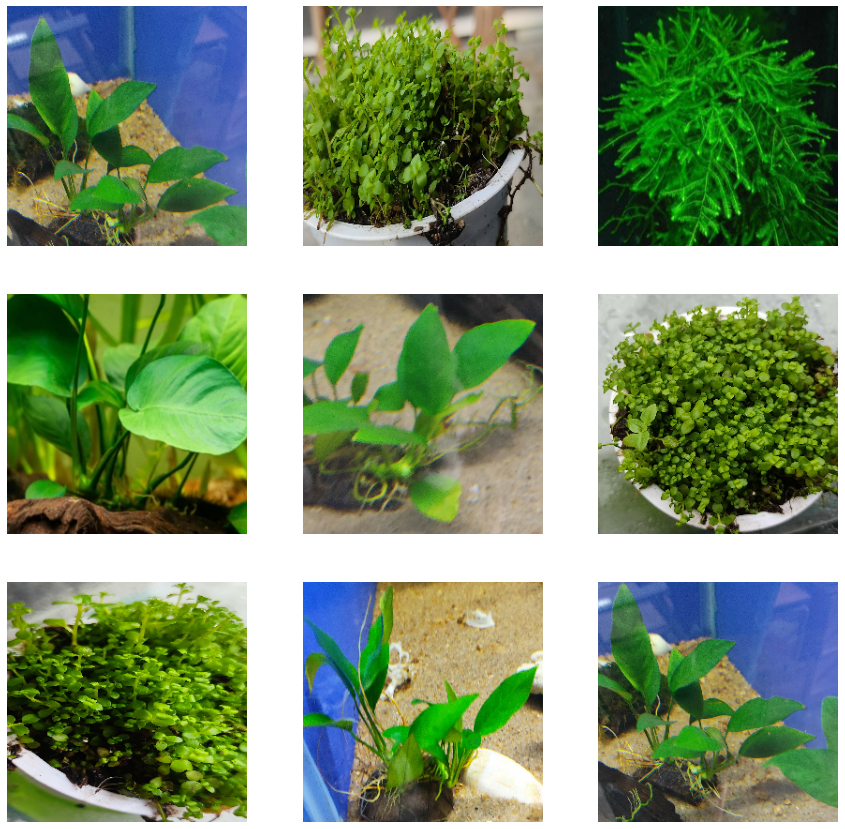

In [ ]:
def show_img(data):
    plt.figure(figsize=(15,15))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

show_img(data)

In [ ]:
pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')

for layer in pre_trained.layers:
    layer.trainable = False

In [ ]:
x = pre_trained.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs = pre_trained.input, outputs = predictions)
model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
STEP_SIZE_TRAIN = train_data.n // train_data.batch_size
STEP_SIZE_VALID = val_data.n // val_data.batch_size

history = model.fit_generator(train_data,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = val_data,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = 4,
                    verbose = 1)

In [ ]:
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='test set')
plt.legend()

In [ ]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

In [ ]:
model_name = 'plants_model.h5'
model.save(model_name, save_format='h5')

In [ ]:
class_map = train_data.class_indices
classes = []
for key in class_map.keys():
    classes.append(key)

In [ ]:
def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(228, 228))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.
    
    prediction = model.predict(img_processed)
    prob = prediction
    print(prob[0])
    
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(str(classes[index]).title()), size=18, color='red')
    plt.imshow(img_array)

In [ ]:
predict_image('/content/gdrive/MyDrive/Plants_dataset/Dataset_Aqatic_Plants/Java Moss/Screenshot 2022-09-25 133120.png', model)

[[9.9999142e-01 8.6171549e-06 6.7493358e-11 3.5314752e-08]]


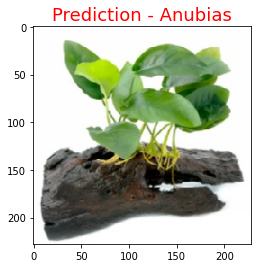

In [ ]:
predict_image('/content/gdrive/MyDrive/Plants_dataset/Dataset_Aqatic_Plants/Anubias/Screenshot 2022-09-24 210140.png', model)

[[1.3296698e-01 8.6661088e-01 6.8977346e-07 4.2143723e-04]]


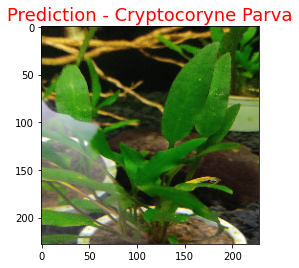

In [ ]:
predict_image('/content/gdrive/MyDrive/Plants_dataset/Dataset_Aqatic_Plants/Cryptocoryne Parva/IMG_20220509_162742.jpg', model)

[[1.0673674e-07 1.8086588e-09 1.2430624e-09 9.9999988e-01]]


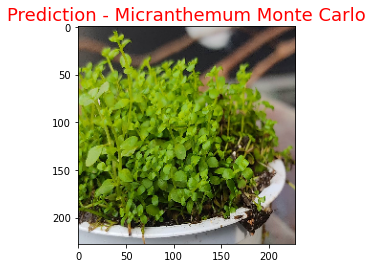

In [ ]:
predict_image('/content/gdrive/MyDrive/Plants_dataset/Dataset_Aqatic_Plants/Micranthemum Monte Carlo/IMG_20220509_162931.jpg', model)